In [90]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

""" class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]
        return x, y """

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.load_data = data[:,0].reshape(-1, 1)
        self.weather_data = data[:,1:]
        self.seq_length = seq_length

    def __len__(self):
        return len(self.load_data) - self.seq_length

    def __getitem__(self, index):
        # x为负荷数据和天气数据的拼接，y为负荷数据
        # 负荷数据一列，天气数据五列
        x = np.concatenate((self.load_data[index:index + self.seq_length].reshape(-1, 1),
                            self.weather_data[index:index + self.seq_length]), axis=1)
        y = self.load_data[index + self.seq_length]
        return x, y



class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 读取训练集和验证集的数据
df = pd.read_csv('data/Area1_Weather_Load_copy.csv')
df = df.drop('Time', axis=1)

def normalize_data(df):
    return (df - df.mean()) / df.std()

df = normalize_data(df)
m_all = len(df) # 数据集总行数
m_val = 271*24 # 验证集数量
m_test = 271*24 # 测试集数量
m_train = m_all - m_test - m_val # 训练集数量
train_df = df.iloc[:m_train]
val_df = df.iloc[m_train:m_train+m_val]
test_df = df.iloc[m_train+m_val:]
print(train_df.shape, val_df.shape, test_df.shape)


(13536, 6) (6504, 6) (6504, 6)


In [91]:
# 将数据集转换为PyTorch的Tensor
train_data = torch.tensor(train_df['Load'].values, dtype=torch.float32).unsqueeze(1)
val_data = torch.tensor(val_df['Load'].values, dtype=torch.float32).unsqueeze(1)

# 创建训练集和验证集的数据集对象
seq_length = 24
train_dataset = TimeSeriesDataset(train_data, seq_length)
val_dataset = TimeSeriesDataset(val_data, seq_length)

# 创建数据加载器
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 定义模型参数
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1

# 创建模型实例
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# 设置训练设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 将模型移动到训练设备
model.to(device)

# 定义训练参数
num_epochs = 10
learning_rate = 0.001

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 初始化最好的验证集损失
best_val_loss = float('inf')

# 训练模型
for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    train_loss = 0.0

    for i, (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    # 在验证集上进行评估
    model.eval()  # 设置模型为评估模式
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

        val_loss /= len(val_dataloader)

    # 打印训练结果
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}], Val Loss: {val_loss:.6f}')

    # 保存最好的模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

print("训练结束了.")

Epoch [1/10], Train Loss: 0.170071], Val Loss: 0.045443
Epoch [2/10], Train Loss: 0.032933], Val Loss: 0.023055
Epoch [3/10], Train Loss: 0.022919], Val Loss: 0.020064
Epoch [4/10], Train Loss: 0.014891], Val Loss: 0.016810
Epoch [5/10], Train Loss: 0.011565], Val Loss: 0.011184
Epoch [6/10], Train Loss: 0.008752], Val Loss: 0.008717
Epoch [7/10], Train Loss: 0.005747], Val Loss: 0.009346
Epoch [8/10], Train Loss: 0.004856], Val Loss: 0.007338
Epoch [9/10], Train Loss: 0.004271], Val Loss: 0.009326
Epoch [10/10], Train Loss: 0.004506], Val Loss: 0.004823
训练结束了.


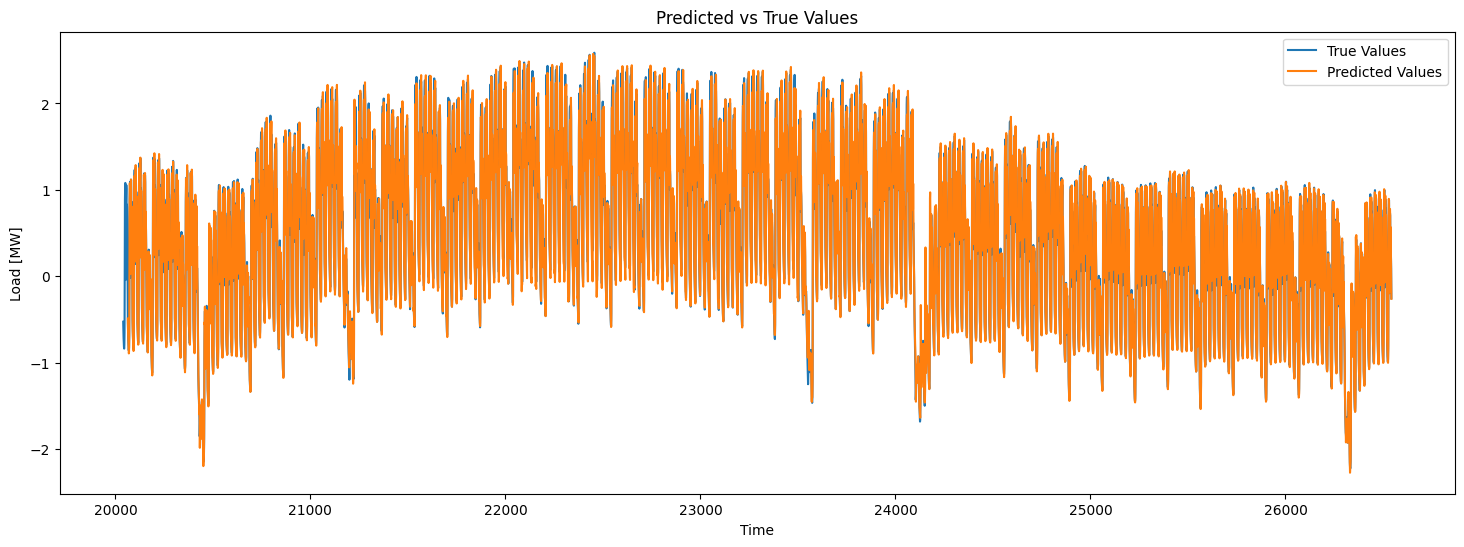

In [92]:
# 将数据集转换为PyTorch的Tensor
test_data = torch.tensor(test_df['Load'].values, dtype=torch.float32).unsqueeze(1)

# 创建测试集的数据集对象
seq_length = 24
test_dataset = TimeSeriesDataset(test_data, seq_length)

# 创建数据加载器
batch_size = 32
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

""" # 定义模型参数
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1

# 创建模型实例
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') """

# 加载已训练好的模型参数
model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()

# 在测试集上进行预测
predictions = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)

        outputs = model(inputs)
        predictions.append(outputs.detach().cpu().numpy())
""" # 预测值和真实值的对比
print("Predicted Values:")
print(predictions)
print("True Values:")
print(test_df['Load'].values[seq_length:])

# 打印预测结果
print("Predictions:")
print(predictions) """

# 将预测结果转换为一维数组
predictions = np.concatenate(predictions).flatten()

# 绘制预测值和真实值的曲线图
plt.figure(figsize=(18, 6))
plt.plot(test_df.index, test_df['Load'], label='True Values')
plt.plot(test_df.index[seq_length:], predictions, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Load [MW]')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()